## Introduction

Business Case - Taking Yelp information to create a Recommendation System with the Surprise model. I want to implement my model to become as successful as those within companies such as Netflix, Amazon, Hulu etc.

Recommendation Systems are very important with consumer retention. When a company invests into brand marketing, it's not a cheap endeavor. So, to make it all-for-not, the consumer retention aspect of the business needs to be strong in order to maintain accounts/viewers. The best way to ensure your business is meeting needs/demands of the consumer, a recommendation system should be put into place to offer similarly liked items/videos to what they are interested in.

## Importing Libraries/JSON Files

In [84]:
# import libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import nltk
# nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize

from surprise import Dataset, Reader
from surprise import BaselineOnly, SVD, SVDpp, NMF
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

# !pip install requests

In [2]:
df1 = pd.read_json('yelp_academic_dataset_business.json', lines=True).dropna(subset=['categories'])
df1.categories

0         Gastropubs, Food, Beer Gardens, Restaurants, B...
1         Salad, Soup, Sandwiches, Delis, Restaurants, C...
2         Antiques, Fashion, Used, Vintage & Consignment...
3                                Beauty & Spas, Hair Salons
4         Gyms, Active Life, Interval Training Gyms, Fit...
                                ...                        
160580    Real Estate, Real Estate Services, Home Servic...
160581        Health Markets, Food, Specialty Food, Grocery
160582    Arts & Entertainment, Paint & Sip, Art Classes...
160583                Cuban, Sandwiches, Restaurants, Cafes
160584    Restaurants, Middle Eastern, Mediterranean, Pe...
Name: categories, Length: 160470, dtype: object

In [3]:
# changing the commas to periods for creating dummy variables
df1['categories'] = df1['categories'].str.replace(',', '.')

In [4]:
vec = CountVectorizer(tokenizer=sent_tokenize, lowercase=False)

categories = vec.fit_transform(df1.dropna(subset=['categories'])['categories'])
categories = pd.DataFrame(categories.toarray(), columns=vec.get_feature_names())
duplicated = [c for c in categories.columns if '.' in c]
categories = categories[duplicated]
categories.columns = [c.strip('.') for c in categories.columns]

In [5]:
categories.columns.unique()

Index(['& Probates', '3D Printing', 'ATV Rentals/Tours', 'Acai Bowls',
       'Accessories', 'Accountants', 'Acne Treatment', 'Active Life',
       'Acupuncture', 'Addiction Medicine',
       ...
       'Wine Tours', 'Wineries', 'Women's Clothing',
       'Workers Compensation Law', 'Wraps', 'Yakiniku', 'Yelp Events', 'Yoga',
       'Ziplining', 'Zoos'],
      dtype='object', length=1350)

In [6]:
categories.sum().sort_values(ascending=False)[:30]

Restaurants                  37139
Food                         22290
Shopping                     20490
Home Services                12344
Beauty & Spas                12089
Health & Medical             11694
Nightlife                     9872
Local Services                9372
Bars                          8872
Event Planning & Services     7736
Active Life                   7199
Automotive                    7199
Sandwiches                    5758
Coffee & Tea                  5724
Fashion                       5346
American (Traditional)        5260
Home & Garden                 4570
Breakfast & Brunch            4440
American (New)                4382
Arts & Entertainment          4204
Hotels & Travel               4177
Hair Salons                   4176
Pizza                         4090
Real Estate                   3964
Fitness & Instruction         3864
Fast Food                     3840
Professional Services         3829
Doctors                       3645
Auto Repair         

In [7]:
# putting the categories df with the original
df2 = pd.concat([df1, categories], axis=1)

In [8]:
df2.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yakiniku,Yelp Events,Yoga,Ziplining,Zoos
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# top 20 categories
categories.sum().sort_values(ascending=False)[:20]

Restaurants                  37139
Food                         22290
Shopping                     20490
Home Services                12344
Beauty & Spas                12089
Health & Medical             11694
Nightlife                     9872
Local Services                9372
Bars                          8872
Event Planning & Services     7736
Active Life                   7199
Automotive                    7199
Sandwiches                    5758
Coffee & Tea                  5724
Fashion                       5346
American (Traditional)        5260
Home & Garden                 4570
Breakfast & Brunch            4440
American (New)                4382
Arts & Entertainment          4204
dtype: int64

In [10]:
# here's how you subset for restaurants and bars (the | acts like an OR)
# this takes a while

restaurants = df2.query('Restaurants == 1 | Bars == 1')
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yakiniku,Yelp Events,Yoga,Ziplining,Zoos
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,ufCxltuh56FF4-ZFZ6cVhg,Sister Honey's,247 E Michigan St,Orlando,FL,32806,28.513265,-81.374707,4.5,135.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,GfWJ19Js7wX9rwaHQ7KbGw,Everything POP Shopping & Dining,1050 Century Dr,Orlando,FL,32830,28.350498,-81.542819,3.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
restaurants.shape

(40357, 1372)

## EDA

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160470 entries, 0 to 160584
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   160470 non-null  object 
 1   name          160470 non-null  object 
 2   address       160470 non-null  object 
 3   city          160470 non-null  object 
 4   state         160470 non-null  object 
 5   postal_code   160470 non-null  object 
 6   latitude      160470 non-null  float64
 7   longitude     160470 non-null  float64
 8   stars         160470 non-null  float64
 9   review_count  160470 non-null  int64  
 10  is_open       160470 non-null  int64  
 11  attributes    145591 non-null  object 
 12  categories    160470 non-null  object 
 13  hours         133241 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 23.4+ MB


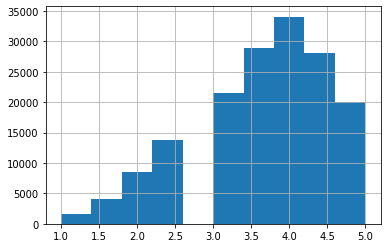

In [13]:
# Not surprising that most reviews are 4. In my opinion, a restaurant is only successful/competitive if its
#    ratings are ranked betweek 3-5 stars.
df1['stars'].hist()

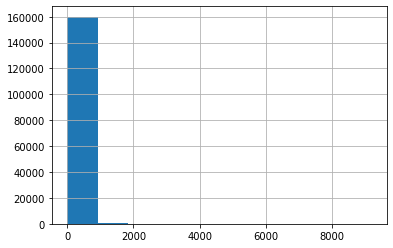

In [14]:
df1['review_count'].hist()

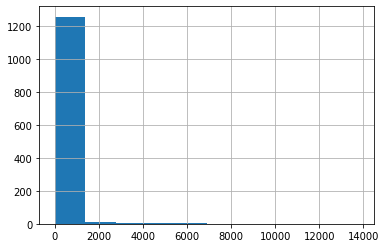

In [15]:
df1['review_count'].value_counts().hist()

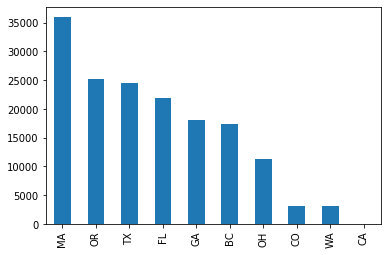

In [16]:
# Majority of ratings are only within 9 states
df1['state'].value_counts()[:10].plot(kind='bar')

In [17]:
# pickle (save) this new list of dictionaries
import pickle

In [18]:
# use this to open the reviews

with open('reviews.pkl', 'rb') as f:
    reviews = pickle.load(f)

In [19]:
reviews = pd.DataFrame(reviews)
reviews

,user_id,business_id,stars
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0
2,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0
3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0
4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0
...,...,...,...
8635398,6olZ0y9oW9azON61AhwxYg,yyTtwwQ4JnQMJ2rn3W0S0g,1.0
8635399,EPYNZQFuSKqLi-on3U9dFg,RDgwjgbu5xziFIAaNn3WCQ,1.0
8635400,tr13Jb83h2itjyXVwaO5eA,rbuj2X4SXIc3MDul4dcxIA,5.0
8635401,HqdmRMpNvScFxjGAB40vgQ,IRzjEZ2pX4iOpnBG7oZJ7g,2.0


In [69]:
# Assigning a variable to new data of the top ten states involved with the dataset because the top ten have 
#  more than one review.

rating_counts = reviews['user_id'].value_counts()[:10]
rating_counts

RtGqdDBvvBCjcu5dUqwfzA    6073
Xwnf20FKuikiHcSpcEbpKQ    3861
tgrs5VQ6thhouiEtMU-N_w    2265
j14WgRoU_-2ZE1aw1dXrJg    1958
jpIGlAym6z88W2xzHiK5_A    1671
9EeEpkZg5jV18N_KvrcT6g    1516
nl8gWLDo6U6MjqzbBmE_9A    1509
R1FVpAyl_BtxHBWdau2VLg    1497
Pf7FI0OukC_CEcCz0ZxoUw    1449
gqL5KBs2oS7qobnyd99iKg    1286
Name: user_id, dtype: int64

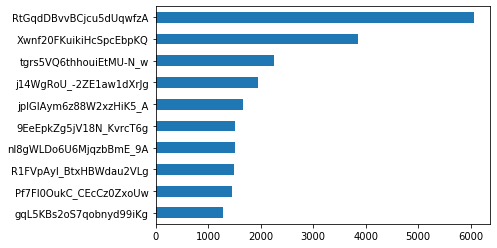

In [21]:
# This will create a horizontal bar graph of the top ten users who rated buisnesses the most.

rating_counts.sort_values().plot(kind='barh')

In [22]:
# Assigning a new variable to call upon that only show the user and their respective review count within data.

user_count = reviews['user_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [23]:
user_count

,unique_values,counts
0,RtGqdDBvvBCjcu5dUqwfzA,6073
1,Xwnf20FKuikiHcSpcEbpKQ,3861
2,tgrs5VQ6thhouiEtMU-N_w,2265
3,j14WgRoU_-2ZE1aw1dXrJg,1958
4,jpIGlAym6z88W2xzHiK5_A,1671
...,...,...
2189452,-YIC6RNgwad72SM48Taf8Q,1
2189453,0tzhQW4TFk0rAimfzBt3fQ,1
2189454,XgXP7GaBmJ5Bfsas-svbnA,1
2189455,GROXfaefwvXir12s2bPRPw,1


In [24]:
# I wanted to remove users that reviewed less than 100x for a few reasons; I wanted to shrink the data for faster
#  processing within my model and to include stronger data of users and their ratings.

user_count[user_count['counts']  > 100]

# You can see that the number of rows decreased over 2 million!! This is a test for further when I select my pool
#  of users to include with the final dataset to enter into the model for predicting.

,unique_values,counts
0,RtGqdDBvvBCjcu5dUqwfzA,6073
1,Xwnf20FKuikiHcSpcEbpKQ,3861
2,tgrs5VQ6thhouiEtMU-N_w,2265
3,j14WgRoU_-2ZE1aw1dXrJg,1958
4,jpIGlAym6z88W2xzHiK5_A,1671
...,...,...
5743,cTVJIVQBfEtsrPW0dM3z4A,101
5744,D_liFPO9WgITdQSun24geA,101
5745,JqEOJxG4J5ybEoBH363jwQ,101
5746,UU4zFYWXQKwqWLlt2veXMQ,101


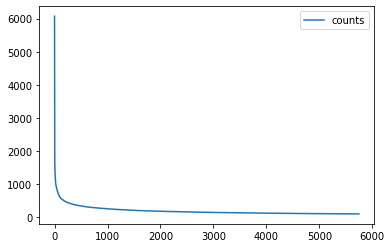

In [25]:
# Here you can see that the top user (6,073 reviews) really skews the data with reviews almost doubling the second 
#  most users vote count. By looking at the graph, on average, users within this dataset review approximately
#  300-500 times.

user_count[user_count['counts']  > 100].plot()

## Surprise Modeling

In [27]:
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(reviews[['user_id', 'business_id', 'stars']], reader)

In [28]:
train, test = train_test_split(data, test_size=.2)

In [29]:
train

### BaselineOnly, SVD, NMF, SVDpp

In [30]:
def model_accuracy(model):
    model.fit(train)
    predictions = model.test(test)
    return accuracy.rmse(predictions)

In [31]:
Base = BaselineOnly()
model_accuracy(Base)

Estimating biases using als...
RMSE: 1.2711


1.2711125758551107

In [32]:
svd = SVD()
model_accuracy(svd)

RMSE: 1.2752


1.275181086489985

In [33]:
NMF = NMF()
model_accuracy(NMF)

RMSE: 1.4345


1.4345435432602005

In [34]:
SVDpp = SVDpp()
model_accuracy(SVDpp)

RMSE: 1.2839


1.2839164997578163

## Subset

In [26]:
# Breaking this code down to easily understand what's going on..
#  Within the df of reviews, I'm selecting the 'user_id' column and finding the values of the users, and then 
#   finding the values of those users reviews.

reviews['user_id'].value_counts().value_counts()

1       1173684
2        363249
3        179185
4        107674
5         70854
         ...   
517           1
518           1
519           1
520           1
6073          1
Name: user_id, Length: 621, dtype: int64

In [51]:
# Assigning new variable to a new list I'm creating of each user and their review counts > 100.

unique_users = user_count[user_count['counts']  > 100]['unique_values'].tolist()

In [35]:
subset = pd.read_csv('review_subset.csv')
subset

,user_id,business_id,stars
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0
2,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0
3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0
4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0
...,...,...,...
19995,nZINe2ni7oR-AxyB7XzVwA,uJFnuF_nYebV_bfNsoGPrQ,3.0
19996,tyN5FVSYgYTh_JAVKyTZag,vUvMI4xCOOvUK8XkbZNNVw,5.0
19997,KBF8F9gANiBZZLNaCEy2fQ,F5_NonP-uoq4v3qplmjiLA,5.0
19998,fUhotHRxeDI13_v1v7yllA,EBIxeySmja_aCq698sVggQ,5.0


In [81]:
# This code subsets the  dataframe if the review df column ['user_id'], list of 'unique_users' made above are within the 
#   outputting a dataframe containing all user's reviews of their buisnesses they 
#  reviewed if the user has more than 100 reviews

reviews_subset = reviews[reviews['user_id'].isin(unique_users)]
reviews_subset

,user_id,business_id,stars
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0
8,LWUnzwK0ILquLLZcHHE1Mw,mD-A9KOWADXvfrZfwDs-jw,4.0
21,ltn9yaWIarK_o4DeMT1duA,MJYb0fioM-X7jc_0RIYyqQ,4.0
23,d01SZKYmReEar7varZB0HQ,I2OblwJG8_XzFxxoHU0vVQ,4.0
29,SIP1Dfwy1M0HWzdgGg9H9g,I-qL4zwr62710OJBtVv28A,4.0
...,...,...,...
8635374,xnf9I953jVkJiqBIIjWJOg,qYANgZTvhdkarq8n1m68bg,4.0
8635381,9U30DANobkrn3Zlu6T9p6Q,biYgFkftCPue7g3upflUOg,4.0
8635383,_6up_KUwL5RsuWtK8fQxXg,vXTo69v2bGEyuBdT0X1hrw,5.0
8635392,mCanGeC78QwvqwSLpnZM_Q,K2XwYhodpeGWW6T57bZ88Q,5.0


In [82]:
reviews_subset['user_id']

1          YoVfDbnISlW0f7abNQACIg
8          LWUnzwK0ILquLLZcHHE1Mw
21         ltn9yaWIarK_o4DeMT1duA
23         d01SZKYmReEar7varZB0HQ
29         SIP1Dfwy1M0HWzdgGg9H9g
                    ...          
8635374    xnf9I953jVkJiqBIIjWJOg
8635381    9U30DANobkrn3Zlu6T9p6Q
8635383    _6up_KUwL5RsuWtK8fQxXg
8635392    mCanGeC78QwvqwSLpnZM_Q
8635393    spFkIHa7x15DJe4gVnSCqw
Name: user_id, Length: 1120549, dtype: object

In [53]:
reader = Reader(rating_scale=(1.0, 5.0))
data_subset = Dataset.load_from_df(reviews_subset[['user_id', 'business_id', 'stars']], reader)

In [54]:
train, test = train_test_split(data_subset, test_size=.2)

In [55]:
train

In [56]:
from surprise import BaselineOnly, SVD, SVDpp, NMF

## Gridsearch CV

In [64]:
svd_param_grid = {'n_factors': [5, 7, 10],
#                   'n_epochs': [5, 15],
#                   'biased': [True, False],
#                   'init_std_dev': [0.001, 0.01, 0.1],
#                   'lr_all': [0.01, 0.05],
                  'reg_all': [0.002, 0.02, 0.1]}

In [65]:
svd_gs = GridSearchCV(algo_class = SVD, param_grid = svd_param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=2)
svd_gs.fit(data_subset)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  9.8min finished


In [66]:
pd.DataFrame(svd_gs.cv_results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_reg_all
0,0.980106,0.981658,0.979044,0.980269,0.001073,7,0.766419,0.767868,0.765718,0.766668,0.000895,7,9.049676,0.118331,3.018490,0.466654,"{'n_factors': 5, 'reg_all': 0.002}",5,0.002
1,0.978653,0.980270,0.977550,0.978824,0.001117,4,0.765563,0.767068,0.765039,0.765890,0.000860,1,8.526776,0.029368,2.795137,0.208446,"{'n_factors': 5, 'reg_all': 0.02}",5,0.020
2,0.978283,0.979759,0.976982,0.978342,0.001135,2,0.766223,0.767719,0.765548,0.766497,0.000907,5,9.219803,0.058407,3.064257,0.244293,"{'n_factors': 5, 'reg_all': 0.1}",5,0.100
3,0.980522,0.982361,0.979196,0.980693,0.001298,8,0.766724,0.768287,0.765809,0.766940,0.001023,8,9.705995,0.060702,2.657734,0.052376,"{'n_factors': 7, 'reg_all': 0.002}",7,0.002
4,0.979058,0.980378,0.977727,0.979054,0.001082,5,0.765814,0.767331,0.765139,0.766095,0.000917,2,9.836866,0.221280,2.850750,0.280115,"{'n_factors': 7, 'reg_all': 0.02}",7,0.020
5,0.978260,0.979823,0.976992,0.978359,0.001158,3,0.766212,0.767796,0.765588,0.766532,0.000930,6,9.499485,0.085871,2.724186,0.041137,"{'n_factors': 7, 'reg_all': 0.1}",7,0.100
6,0.981236,0.982733,0.980068,0.981345,0.001091,9,0.767314,0.768742,0.766504,0.767520,0.000925,9,10.800063,0.455617,2.803515,0.139282,"{'n_factors': 10, 'reg_all': 0.002}",10,0.002
7,0.979261,0.980490,0.978037,0.979263,0.001002,6,0.766068,0.767260,0.765394,0.766241,0.000771,3,10.896671,0.237844,2.900548,0.271300,"{'n_factors': 10, 'reg_all': 0.02}",10,0.020
8,0.978091,0.979818,0.976947,0.978285,0.001180,1,0.766097,0.767806,0.765511,0.766471,0.000973,4,10.823039,0.291049,2.924058,0.584704,"{'n_factors': 10, 'reg_all': 0.1}",10,0.100


## Final Tuning to Model

In [44]:
def model_subset_accuracy(model):
    model.fit(train)
    predictions = model.test(test)
    return accuracy.rmse(predictions)

In [45]:
Base = BaselineOnly()
model_subset_accuracy(Base)

Estimating biases using als...
RMSE: 1.3399


1.3399290518580924

In [46]:
nmf = NMF()
model_subset_accuracy(nmf)

RMSE: 1.4175


1.41753782687693

In [47]:
svd = SVD()
model_subset_accuracy(svd)

RMSE: 1.3383


1.3383389720236696

In [68]:
svd = SVD(n_factors = 10, reg_all = 0.020)
model_subset_accuracy(svd)

RMSE: 0.9759


0.97591091545306

In [67]:
svd = SVD(n_factors = 5, reg_all = 0.020)
model_subset_accuracy(svd)

RMSE: 0.9755


0.9755303135614181

## Yelp API Access

In [75]:
from config import zach_key

In [101]:
import requests
biz = 'RA4V8pr014UyUbDvI-LW2A'

url = 'https://api.yelp.com/v3/businesses/RA4V8pr014UyUbDvI-LW2A'

headers = {
        'Authorization': 'Bearer {}'.format(zach_key),
    }

response = requests.get(url, headers=headers).json()
print(response)
# print(type(response.text))
# print(response.text[:1000])

{'id': 'RA4V8pr014UyUbDvI-LW2A', 'alias': 'target-framingham', 'name': 'Target', 'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/3oIqg5HwKoY4-ns1kj95uw/o.jpg', 'is_claimed': True, 'is_closed': False, 'url': 'https://www.yelp.com/biz/target-framingham?adjust_creative=oFV8I1v9o6Rqh1sMs1MziQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_lookup&utm_source=oFV8I1v9o6Rqh1sMs1MziQ', 'phone': '+15086283136', 'display_phone': '(508) 628-3136', 'review_count': 66, 'categories': [{'alias': 'deptstores', 'title': 'Department Stores'}, {'alias': 'furniture', 'title': 'Furniture Stores'}, {'alias': 'electronics', 'title': 'Electronics'}], 'rating': 3.0, 'location': {'address1': '400 Cochituate Rd', 'address2': '', 'address3': '', 'city': 'Framingham', 'zip_code': '01701', 'country': 'US', 'state': 'MA', 'display_address': ['400 Cochituate Rd', 'Framingham, MA 01701'], 'cross_streets': ''}, 'coordinates': {'latitude': 42.305328, 'longitude': -71.398387}, 'photos': ['https://s3-media1.fl.y

In [109]:
df = pd.DataFrame[response['results']]
df

KeyError: 'results'

In [86]:
response.keys()

dict_keys(['id', 'alias', 'name', 'image_url', 'is_claimed', 'is_closed', 'url', 'phone', 'display_phone', 'review_count', 'categories', 'rating', 'location', 'coordinates', 'photos', 'price', 'hours', 'transactions', 'messaging'])

In [89]:
for key in response.keys():
    print(key)
    value = response[key] #Use standard dictionary formatting
    print(type(value)) #What type is it?
    print('\n\n') #Separate out data

id
<class 'str'>



alias
<class 'str'>



name
<class 'str'>



image_url
<class 'str'>



is_claimed
<class 'bool'>



is_closed
<class 'bool'>



url
<class 'str'>



phone
<class 'str'>



display_phone
<class 'str'>



review_count
<class 'int'>



categories
<class 'list'>



rating
<class 'float'>



location
<class 'dict'>



coordinates
<class 'dict'>



photos
<class 'list'>



price
<class 'str'>



hours
<class 'list'>



transactions
<class 'list'>



messaging
<class 'dict'>





In [93]:
response['name']

'Target'

In [106]:
top_ten_most_reviews = reviews['business_id'].value_counts()[:10]
top_ten_most_reviews

4CxF8c3MB7VAdY8zFb2cZQ    9295
OQ2oHkcWA8KNC1Lsvj1SBA    7394
PrsvO1rzkgg6qFizlAoEtg    7385
zioLxtBc9THNS2TOn9xW1w    6325
y2w6rFaO0XEiG5mFfOsiFA    5220
MGzro82Fi4LYvc86acoONQ    5071
cs6HfZNykLVitm09jWFqWg    4901
bZiIIUcpgxh8mpKMDhdqbA    4818
qLJUDPOamhLdbtfbcWyHnA    4628
n73rxa6e6-fTIxQzfv4BuA    4560
Name: business_id, dtype: int64

In [105]:
biz = '4CxF8c3MB7VAdY8zFb2cZQ'

url = 'https://api.yelp.com/v3/businesses/4CxF8c3MB7VAdY8zFb2cZQ'

headers = {
        'Authorization': 'Bearer {}'.format(zach_key),
    }

response = requests.get(url, headers=headers).json()
print(response)

{'id': '4CxF8c3MB7VAdY8zFb2cZQ', 'alias': 'voodoo-doughnut-portland-5', 'name': 'Voodoo Doughnut', 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/_bSEBNg96NsLIGMlo8qgag/o.jpg', 'is_claimed': True, 'is_closed': False, 'url': 'https://www.yelp.com/biz/voodoo-doughnut-portland-5?adjust_creative=oFV8I1v9o6Rqh1sMs1MziQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_lookup&utm_source=oFV8I1v9o6Rqh1sMs1MziQ', 'phone': '+15032414704', 'display_phone': '(503) 241-4704', 'review_count': 9226, 'categories': [{'alias': 'donuts', 'title': 'Donuts'}], 'rating': 3.5, 'location': {'address1': '22 SW 3rd Ave', 'address2': '', 'address3': '', 'city': 'Portland', 'zip_code': '97204', 'country': 'US', 'state': 'OR', 'display_address': ['22 SW 3rd Ave', 'Portland, OR 97204'], 'cross_streets': ''}, 'coordinates': {'latitude': 45.5226120114276, 'longitude': -122.673083611421}, 'photos': ['https://s3-media3.fl.yelpcdn.com/bphoto/_bSEBNg96NsLIGMlo8qgag/o.jpg', 'https://s3-media4.fl.yelpcdn.com/bpho